# Diagnostics for Neural Posterior Estimation

**Time: ~10 minutes**

In the previous notebooks, we:
1. **Notebook 3**: Learned the `sbi` workflow for NPE
2. **Notebook 4**: Explored different summary statistics

Now comes a critical question:

> **How do we know if our posterior is trustworthy?**

Neural networks can fail silently — they might produce confident-looking but wrong results! Before using our inference for real decisions, we need **diagnostic checks**.

## What We'll Learn

1. **Training Diagnostics**: Did the neural network converge properly?
2. **Posterior Predictive Checks**: Can we recreate the observed data from our posterior?
3. **Simulation-Based Calibration (SBC)**: Are our uncertainty estimates reliable?

**Documentation**: [sbi Bayesian workflow](https://sbi.readthedocs.io/en/stable/tutorials/01_Bayesian_workflow.html)

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np

from sbi.inference import NPE, simulate_for_sbi
from sbi.analysis import pairplot, sbc_rank_plot
from sbi.diagnostics import run_sbc, check_sbc

from simulators import (
    create_lotka_volterra_prior,
    generate_observed_data,
    lotka_volterra_simulator,
    simulate,
)

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

---
## Setup: Quick NPE Training

First, let's quickly train an NPE on the Lotka-Volterra model (using what we learned in Notebook 3).

**Just run these cells** — we'll focus on diagnostics, not training!

In [2]:
# Setup prior and observed data
prior = create_lotka_volterra_prior()
x_o, theta_o = generate_observed_data(use_autocorrelation=True)

# For visualization later
time = np.arange(0, 200, 0.1)
ts_observed = simulate(theta_o.numpy())

In [3]:
# Train NPE
num_simulations = 1_000

theta = prior.sample((num_simulations,))
x = lotka_volterra_simulator(theta, use_autocorrelation=True)

npe = NPE(prior)
npe.append_simulations(theta, x).train()

posterior = npe.build_posterior()
samples = posterior.sample((10_000,), x=x_o)

print(f"\nNPE trained! Posterior samples shape: {samples.shape}")

 Neural network successfully converged after 391 epochs.

  0%|          | 0/10000 [00:00<?, ?it/s]


NPE trained! Posterior samples shape: torch.Size([10000, 4])


---
## Think First!

Before we run diagnostics, let's think about why they matter:

**Question 1**: Why do we need diagnostics for NPE? Can't we just trust the posterior samples?

**Question 2**: What is a "posterior predictive check"? What should we expect if inference worked well?

**Question 3**: If our posterior says "90% credible interval", how can we verify this is actually correct?

<details>
<summary>Click to reveal answers</summary>

1. **Why diagnostics?**
   - Neural networks can fail silently — they might give confident but wrong answers
   - The posterior might be too narrow (overconfident) or too wide (uninformative)
   - We can't know if inference worked without checking!

2. **Posterior predictive check:**
   - Sample parameters from the posterior → simulate new data → compare to observed data
   - If inference worked well, simulated data should look similar to the observation
   - The observed data should fall within the distribution of posterior simulations

3. **Verifying calibration:**
   - Use **Simulation-Based Calibration (SBC)**
   - Run many "fake experiments" where we know the true parameters
   - Check: Does the 90% credible interval contain the truth ~90% of the time?
   - If yes → our uncertainty estimates are reliable!

</details>

---
## Part 1: Training Diagnostics

**The question**: Did the neural network converge during training?

Before we trust the posterior, we should verify that training went well:
- **Training loss** should decrease and stabilize
- **Validation loss** should not increase (no overfitting)
- Both should converge to a plateau

The `sbi` package stores training statistics that we can visualize with `npe.summary`. 

**Documentation**: See the [sbi Bayesian workflow tutorial](https://sbi.readthedocs.io/en/stable/tutorials/01_Bayesian_workflow.html) for more details on training diagnostics.

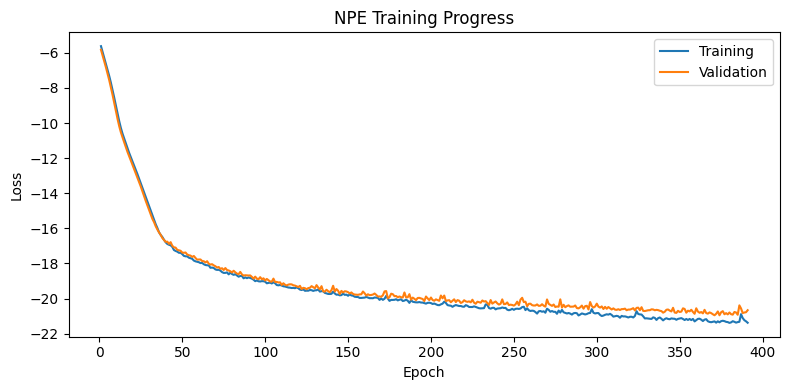

Check: Both loss curves should increase and stabilize (converge).
   If validation loss decreases → overfitting (need more data or regularization)
   If loss curves are still increasing → train longer (increase max_num_epochs)


In [4]:
# Visualize training progress using npe.summary
# The summary dict contains training and validation loss

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# Plot training and validation loss
train_loss = npe.summary["training_loss"]
val_loss = npe.summary["validation_loss"]
epochs = range(1, len(train_loss) + 1)

ax.plot(epochs, train_loss, label="Training")
ax.plot(epochs, val_loss, label="Validation")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("NPE Training Progress")
ax.legend()

plt.tight_layout()
plt.show()

print("Check: Both loss curves should increase and stabilize (converge).")
print("   If validation loss decreases → overfitting (need more data or regularization)")
print("   If loss curves are still increasing → train longer (increase max_num_epochs)")

---
## Part 2: Posterior Predictive Check

**The idea**: If our posterior is good, then data simulated from posterior parameters should look like the observed data.

**The process**:
1. Sample parameters from the posterior: θ ~ q(θ|x_o)
2. Simulate new data for each parameter: x_sim ~ p(x|θ)
3. Compare x_sim to x_o — they should be similar!

This is the most intuitive diagnostic: *"Can our posterior explain what we observed?"*

In [5]:
# Helper function for posterior predictive visualization
def plot_posterior_predictive(samples, ts_observed, time, n_samples=50, title=""):
    """Plot posterior predictive simulations vs ground truth."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Sample some posterior parameters and simulate
    indices = np.random.choice(len(samples), size=n_samples, replace=False)

    for idx in indices:
        theta_sample = samples[idx].numpy()
        ts_sample = simulate(theta_sample)
        axes[0].plot(time, ts_sample[:, 0], color="C0", alpha=0.15, linewidth=0.5)
        axes[1].plot(time, ts_sample[:, 1], color="C1", alpha=0.15, linewidth=0.5)

    # Plot ground truth
    axes[0].plot(time, ts_observed[:, 0], color="black", linewidth=2, label="Observed")
    axes[1].plot(time, ts_observed[:, 1], color="black", linewidth=2, label="Observed")

    # Formatting
    axes[0].set_xlabel("Time (days)")
    axes[0].set_ylabel("Population")
    axes[0].set_title(f"Prey - {title}")
    axes[0].plot([], [], color="C0", alpha=0.5, label="Posterior simulations")
    axes[0].legend()

    axes[1].set_xlabel("Time (days)")
    axes[1].set_ylabel("Population")
    axes[1].set_title(f"Predator - {title}")
    axes[1].plot([], [], color="C1", alpha=0.5, label="Posterior simulations")
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    return fig

### Your Task: Run a Posterior Predictive Check

Use the `plot_posterior_predictive` function to visualize how well simulations from the posterior match the observed data.

**Question**: Do the posterior simulations capture the observed dynamics? Are they too spread out or too narrow?

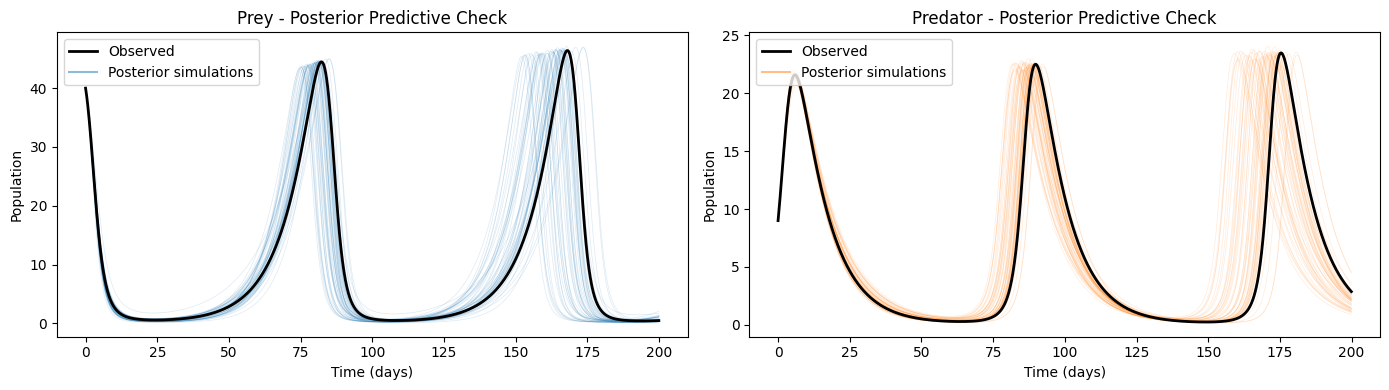

Check: Do the posterior curves cluster around the black 'observed' line?
   If yes → the posterior can explain the observation!
   If no  → something might be wrong with inference.


In [6]:
# SOLUTION: Posterior Predictive Check
# TODO for students: call plot_posterior_predictive with the right arguments

plot_posterior_predictive(
    samples, ts_observed, time,
    n_samples=50, title="Posterior Predictive Check"
)

print("Check: Do the posterior curves cluster around the black 'observed' line?")
print("   If yes → the posterior can explain the observation!")
print("   If no  → something might be wrong with inference.")

---
## Part 3: Simulation-Based Calibration (SBC)

**The question**: When our posterior says "90% credible interval", is it correct 90% of the time?

**The method**:
1. Sample "true" parameters from the prior: θ* ~ p(θ)
2. Simulate fake observations: x* ~ p(x|θ*)
3. Run inference to get posterior: q(θ|x*)
4. Check: Where does θ* fall in the posterior?
5. Repeat many times and check if θ* ranks are uniformly distributed

**Why uniform?** If the posterior is well-calibrated, the true parameter should be equally likely to fall anywhere in the posterior distribution.

### What Can Go Wrong?

| Rank Distribution | Problem | Meaning |
|-------------------|---------|----------|
| **∩-shaped** (hump in middle) | Underconfident | Posteriors too wide |
| **∪-shaped** (humps at edges) | Overconfident | Posteriors too narrow |
| **Skewed** | Biased | Systematic error in one direction |

### Your Task: Run SBC

Complete the code below to run simulation-based calibration.

**Hints**:
- Use `simulate_for_sbi(simulator, prior, num_simulations)` to generate test data
- Use `run_sbc(thetas, xs, posterior, num_posterior_samples)` to compute ranks
- Use `sbc_rank_plot(ranks, num_posterior_samples)` to visualize results

In [18]:
# SOLUTION: Generate test data for SBC
# We simulate new (theta, x) pairs to test if our posterior is well-calibrated

num_sbc_runs = 200  # Number of test cases (use 500+ in practice)
num_posterior_samples = 1000  # Samples per posterior

print(f"Running SBC with {num_sbc_runs} test cases...")
print("(This tests: 'Are our credible intervals trustworthy?')\n")

# TODO for students: Generate test data using simulate_for_sbi
# Hint: we need (theta, x) pairs from the prior

def sbc_simulator(theta):
    return lotka_volterra_simulator(theta, use_autocorrelation=True)

thetas_sbc, xs_sbc = simulate_for_sbi(
    sbc_simulator,
    prior,
    num_simulations=num_sbc_runs,
)

print(f"Generated {num_sbc_runs} test (θ, x) pairs")
print(f"  thetas shape: {thetas_sbc.shape}")
print(f"  xs shape: {xs_sbc.shape}")

Running SBC with 200 test cases...
(This tests: 'Are our credible intervals trustworthy?')



  0%|          | 0/200 [00:00<?, ?it/s]

Generated 200 test (θ, x) pairs
  thetas shape: torch.Size([200, 4])
  xs shape: torch.Size([200, 20])


In [19]:
# SOLUTION: Run SBC to compute ranks
# For each test case, we check where the true theta falls in the posterior

# TODO for students: Use run_sbc to compute ranks
# Hint: run_sbc(thetas, xs, posterior, num_posterior_samples, reduce_fns="marginals")

ranks, dap_samples = run_sbc(
    thetas_sbc,
    xs_sbc,
    posterior,
    num_posterior_samples=num_posterior_samples,
    reduce_fns="marginals",
)

print(f"\nComputed ranks for {num_sbc_runs} test cases")
print(f"Ranks shape: {ranks.shape} (one rank per parameter per test case)")

Drawing 1000 samples for 200 observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating ranks for 200 SBC samples:   0%|          | 0/200 [00:00<?, ?it/s]


Computed ranks for 200 test cases
Ranks shape: torch.Size([200, 4]) (one rank per parameter per test case)


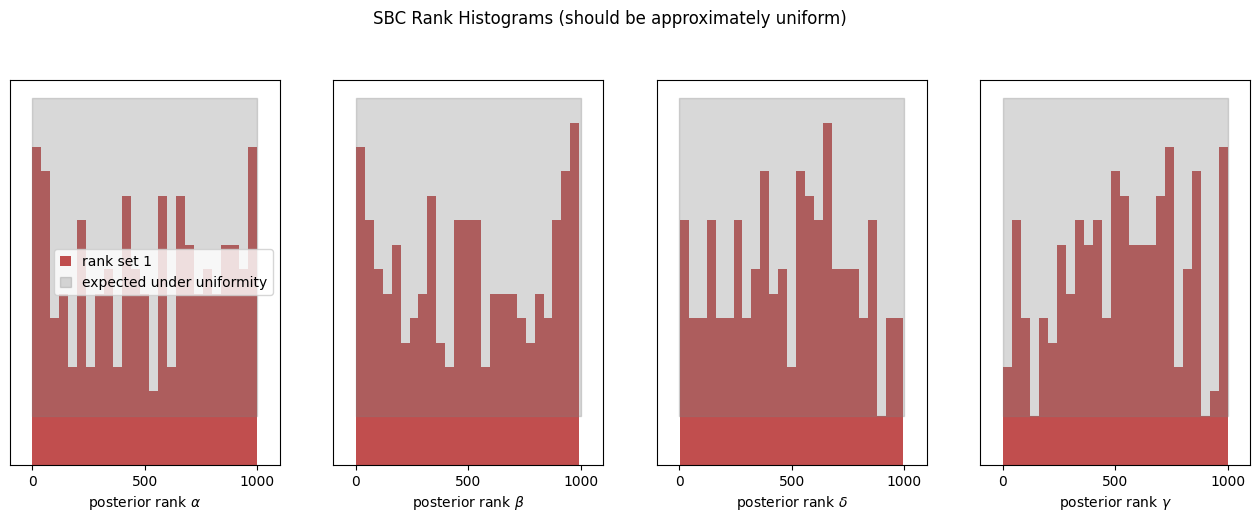


Interpretation:
   - Flat histogram → well-calibrated posterior
   - ∩-shaped → underconfident (posteriors too wide)
   - ∪-shaped → overconfident (posteriors too narrow)
   - Skewed → biased estimates


In [23]:
# SOLUTION: Visualize SBC results
# Well-calibrated posteriors → uniform rank distribution (flat histogram)

param_labels = [r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"]

# TODO for students: Use sbc_rank_plot to visualize
fig, ax = sbc_rank_plot(
    ranks,
    num_posterior_samples=num_posterior_samples,
    parameter_labels=param_labels,
    plot_type="hist",
    num_bins=25,
)
plt.suptitle("SBC Rank Histograms (should be approximately uniform)", y=1.02)
plt.show()

print("\nInterpretation:")
print("   - Flat histogram → well-calibrated posterior")
print("   - ∩-shaped → underconfident (posteriors too wide)")
print("   - ∪-shaped → overconfident (posteriors too narrow)")
print("   - Skewed → biased estimates")

---
## Summary

### Diagnostic Toolkit

| Diagnostic | What it checks | What to look for |
|------------|----------------|------------------|
| **Training Loss** | Did the network converge? | Loss decreases and stabilizes |
| **Posterior Predictive** | Can posterior explain observations? | Simulations should match observed data |
| **SBC** | Are credible intervals calibrated? | Uniform rank histograms |

### Key Takeaways

1. **Always validate** — Neural networks can fail silently
2. **Training diagnostics** — Check loss curves for convergence and overfitting
3. **Posterior predictive checks** — Intuitive sanity check: "Does this make sense?"
4. **SBC for calibration** — Quantitative check: "Can we trust the uncertainties?"
5. **Iterate if needed** — Poor diagnostics → adjust and retrain

### The `sbi` Pattern for Diagnostics

```python
# Training diagnostics
train_losses = npe.summary["training_log_probs"]
val_losses = npe.summary["validation_log_probs"]

# Posterior predictive check
theta_samples = posterior.sample((N,), x=x_o)
x_predicted = simulator(theta_samples)
# Compare x_predicted to x_o

# Simulation-based calibration
from sbi.diagnostics import run_sbc, check_sbc
from sbi.analysis import sbc_rank_plot

thetas, xs = simulate_for_sbi(simulator, prior, num_simulations=200)
ranks, dap = run_sbc(thetas, xs, posterior, num_posterior_samples=1000)
sbc_rank_plot(ranks, num_posterior_samples=1000)
```

For more details, see the [sbi Bayesian workflow tutorial](https://sbi.readthedocs.io/en/stable/tutorials/01_Bayesian_workflow.html).

---

## Learning Goals

After this notebook, you should be able to:

- ✅ Explain why diagnostics are essential for SBI
- ✅ Check training convergence using `npe.summary`
- ✅ Run posterior predictive checks to validate inference
- ✅ Use simulation-based calibration (SBC) to test calibration
- ✅ Interpret SBC rank histograms and identify problems